<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>

# Introduction to Financial Analytics and Time Series Data 

*This lab was developed by: <br> Jose Luis Rodriguez, Director of Margolis Market Information Lab, R.C. Evans Innovation Fellow at Gies College of Business
<br> Esther Meng, MS Statistics, Department of Statistics at University of Illinois, Urbana-Champaign*

#### On this lab we will introduce an overview of financial analytics. Students will learn why, when, and how to apply financial analytics to real-world datasets. 

* Develop a basic understanding about financial analytics: its definition and specific examples
* Utilize an overview framework of financial analytics to generalize the procedure of financial analysis: the source of data, tools to analyze it, and its application for enhancing operating performance (from automate to transform and automate)
* Understand time series data and how to deal with time series data using R codes to generate forecasting models that can be applied to enhance business performance

### Packages and Configurations
The following packages are required for this lab exercise:

* tidyverse: https://www.tidyverse.org/
* lubridate: https://lubridate.tidyverse.org/
* forecast: https://cran.r-project.org/web/packages/forecast/
* xts: https://cran.r-project.org/web/packages/xts

In [1]:
# SUPPRESS PACKAGE WARNINGS
quietly <- suppressPackageStartupMessages

# DISABLE SCIENTIFIC NOTATION
options(scipen = 9999)

# LOAD PACKAGES SUPRESS WARNINGS
quietly(library(xts))
quietly(library(tidyverse))
quietly(library(lubridate))
quietly(library(forecast))

### Data Import and Exploration

In [2]:
# Import the kraken dataset as kraken_df
kraken_df = read_csv("data/kraken.csv") 

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  crypto = col_character(),
  pct_change = col_double(),
  price = col_double(),
  volume = col_double(),
  trend = col_character(),
  all_time_high = col_logical(),
  new_crypto = col_logical()
)



Display the first couple of rows of the dataset we just read into R
- Using head() function

In [3]:
head(kraken_df)

datetime,crypto,pct_change,price,volume,trend,all_time_high,new_crypto
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
2020-08-05 03:48:49,XBT,0.0040,11194.0000,111100000,down,FALSE,FALSE
2020-08-05 03:48:49,ETH,0.0080,389.8100,68800000,up,FALSE,FALSE
2020-08-05 03:48:49,XRP,0.0320,0.3010,20300000,down,FALSE,FALSE
2020-08-05 03:48:49,USDT,0.0001,1.0005,18600000,down,FALSE,FALSE
2020-08-05 03:48:49,LINK,0.0650,9.8602,14800000,up,FALSE,FALSE
2020-08-05 03:48:49,XTZ,0.0540,3.2424,10300000,up,FALSE,FALSE


#### Data Pre-processing
We will do some variable convertion in the following two cells: 
1. Change the __trend__ variable to numeric (up/down/flat to 1/-1/0)
2. Update the __datetime__ object to two varibles, date and time (hours-minutes-seconds)
3. Make the __crypto__ variable from character to factor
4. Do binary encoding on __all_time_high__ and __new_crypto__ variables (TRUE = 1, FALSE = 0)

In [4]:
kraken_df$trend = kraken_df$trend %>%
                    str_replace_all("up","1") %>% 
                    str_replace_all("down","-1") %>%
                    str_replace_all("flat","0") %>%
                    as.numeric()

In [5]:
kraken_df$date = as.Date(kraken_df$datetime)
kraken_df$time = format(kraken_df$datetime,"%H:%M:%S")
kraken_df$crypto = as_factor(kraken_df$crypto)
kraken_df$all_time_high = as.numeric(kraken_df$all_time_high)
kraken_df$new_crypto = as.numeric(kraken_df$new_crypto)

Let's check out the summary statistics of variables we have:

In [6]:
summary(kraken_df[c("date","crypto","price","volume")])

      date                crypto          price               volume         
 Min.   :2017-06-12   XBT    : 1053   Min.   :    0.001   Min.   :      518  
 1st Qu.:2018-05-16   ETH    : 1053   1st Qu.:    1.000   1st Qu.:   286709  
 Median :2019-04-01   XRP    : 1053   Median :   11.560   Median :  1090000  
 Mean   :2019-03-06   USDT   : 1053   Mean   :  487.156   Mean   : 11007116  
 3rd Qu.:2020-01-19   LTC    : 1053   3rd Qu.:  114.770   3rd Qu.:  4440000  
 Max.   :2020-08-05   XLM    : 1053   Max.   :19020.000   Max.   :829000000  
                      (Other):12967                                          

In [7]:
summary(kraken_df[c("trend","pct_change","all_time_high", "new_crypto")])

     trend            pct_change      all_time_high        new_crypto      
 Min.   :-1.00000   Min.   :0.00000   Min.   :0.000000   Min.   :0.000000  
 1st Qu.:-1.00000   1st Qu.:0.00960   1st Qu.:0.000000   1st Qu.:0.000000  
 Median : 0.00000   Median :0.02480   Median :0.000000   Median :0.000000  
 Mean   :-0.01177   Mean   :0.04029   Mean   :0.007156   Mean   :0.001141  
 3rd Qu.: 1.00000   3rd Qu.:0.05300   3rd Qu.:0.000000   3rd Qu.:0.000000  
 Max.   : 1.00000   Max.   :1.07400   Max.   :1.000000   Max.   :1.000000  

### Exploring XBT:
In the following section, we will choose XBT as an example to demonstrate financial analytics
- Extract a subset from original dataset, kraken_df, using XBT as the target crypto type
- Named the subset xbt_df

In [8]:
xbt_df = kraken_df[kraken_df$crypto == "XBT",]

# Remove the crypto column in extracted subset
xbt_df = select(xbt_df, -c("crypto"))

In [9]:
head(xbt_df)

datetime,pct_change,price,volume,trend,all_time_high,new_crypto,date,time
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>
2020-08-05 03:48:49,0.0040,11194,111100000,-1,0,0,2020-08-05,03:48:49
2020-08-04 03:28:35,0.0160,11246,134400000,1,0,0,2020-08-04,03:28:35
2020-08-03 02:56:14,0.0610,11084,250500000,-1,0,0,2020-08-03,02:56:14
2020-08-02 02:24:13,0.0400,11820,201400000,1,0,0,2020-08-02,02:24:13
2020-08-01 02:57:23,0.0200,11350,144700000,1,0,0,2020-08-01,02:57:23
2020-07-31 03:17:57,0.0005,11117,130800000,1,0,0,2020-07-31,03:17:57


As the date and time variables created in previous step to represent the original datetime feature, we can remove the datetime feature now

Next, we sort our XBT data by date and time in ascending order

In [10]:
dt = select(xbt_df,c("datetime"))$datetime
xbt_ts = xts(select(xbt_df,-c("datetime","date","time")), 
             order.by = as.POSIXct(strptime(dt,"%Y-%m-%d %H:%M:%S")))

In [11]:
# Display the beginning of XBT dataset
head(xbt_ts)

                    pct_change price    volume trend all_time_high new_crypto
2017-06-12 21:07:38     0.1030  2593  94900000    -1             0          0
2017-06-13 21:07:38     0.0473  2715  75200000     1             0          0
2017-06-14 21:07:38     0.0588  2556  76800000    -1             0          0
2017-06-15 21:07:38     0.0875  2332 135000000    -1             0          0
2017-06-16 21:04:35     0.0694  2494  73900000     1             0          0
2017-06-17 21:07:38     0.0557  2633  49000000     1             0          0

#### Several prices are summarized in the following cell:
1. daily_price: daily price from the price column
2. weely_price: weekly average price of XBT 
3. monthly_price: monthly average price of XBT
4. quarterly_price: quarterly average price of XBT

They will be to plot price curves in later sections.

In [12]:
daily_price = xbt_ts[,'price']
weekly_price = apply.weekly(daily_price, mean)
monthly_price = apply.monthly(daily_price, mean)
quarterly_price = apply.quarterly(daily_price, mean)

### XBT Daily Prices - June 2017 to June 2020

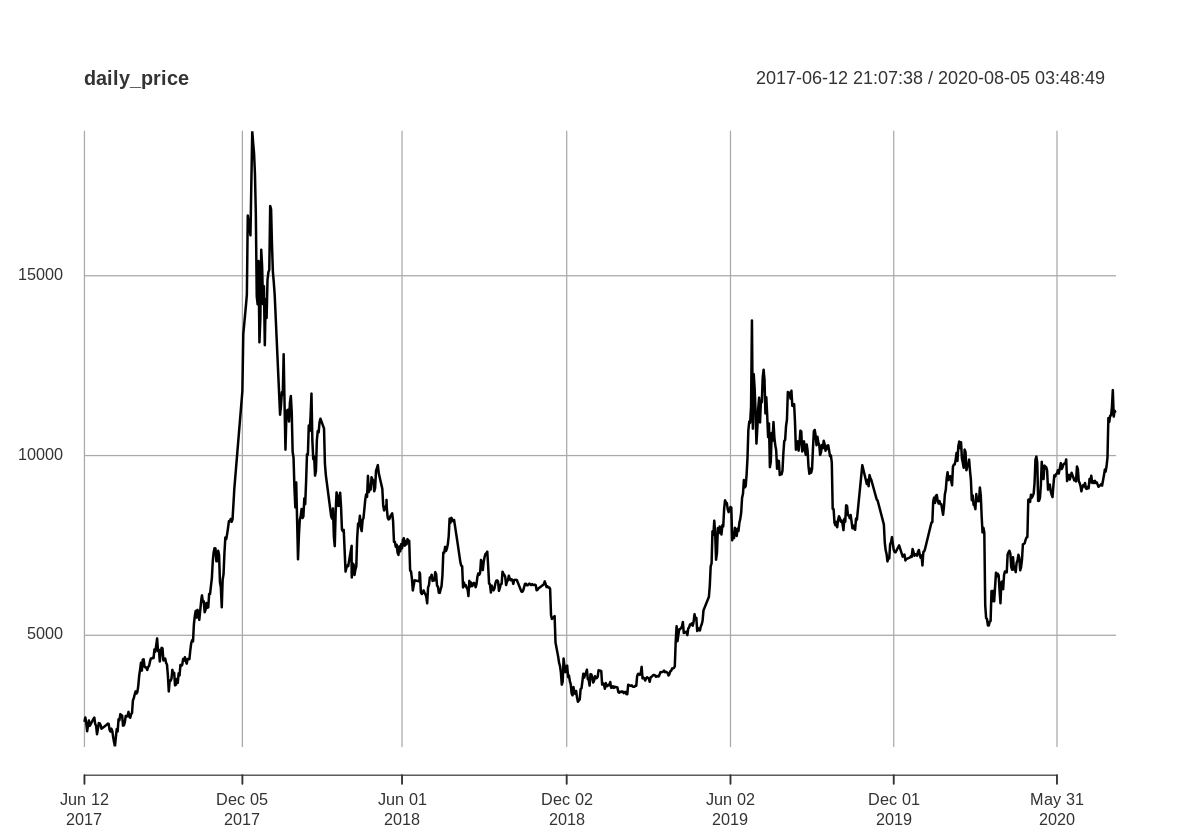

In [13]:
# Adjusting figure size, you can change the width and height
options(repr.plot.width=10, repr.plot.height=7) 

# Plot XBT daily prices over time 
plot(daily_price, yaxis.right = FALSE)

### XBT Weekly Prices - June 2017 to June 2020

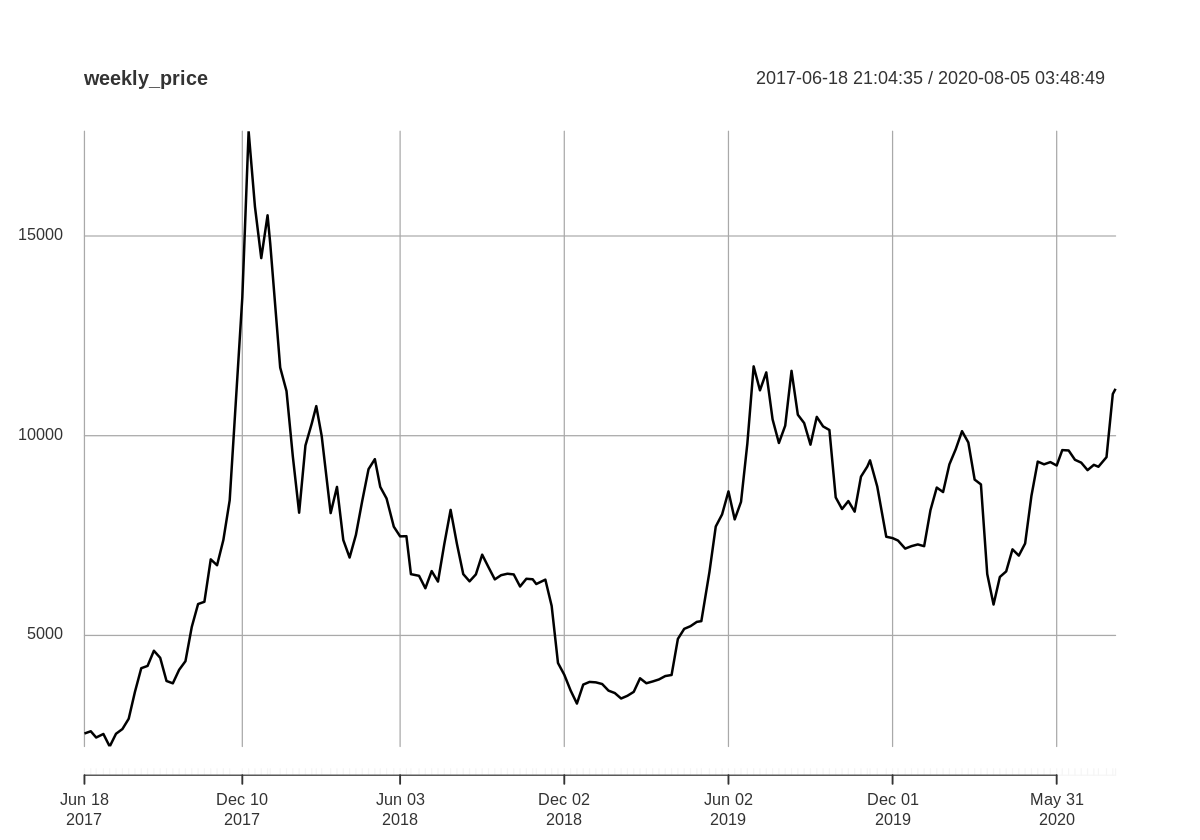

In [14]:
# Plot XBT weekly average prices over time 
plot(weekly_price, yaxis.right = FALSE)

### XBT Monthly Prices - June 2017 to June 2020

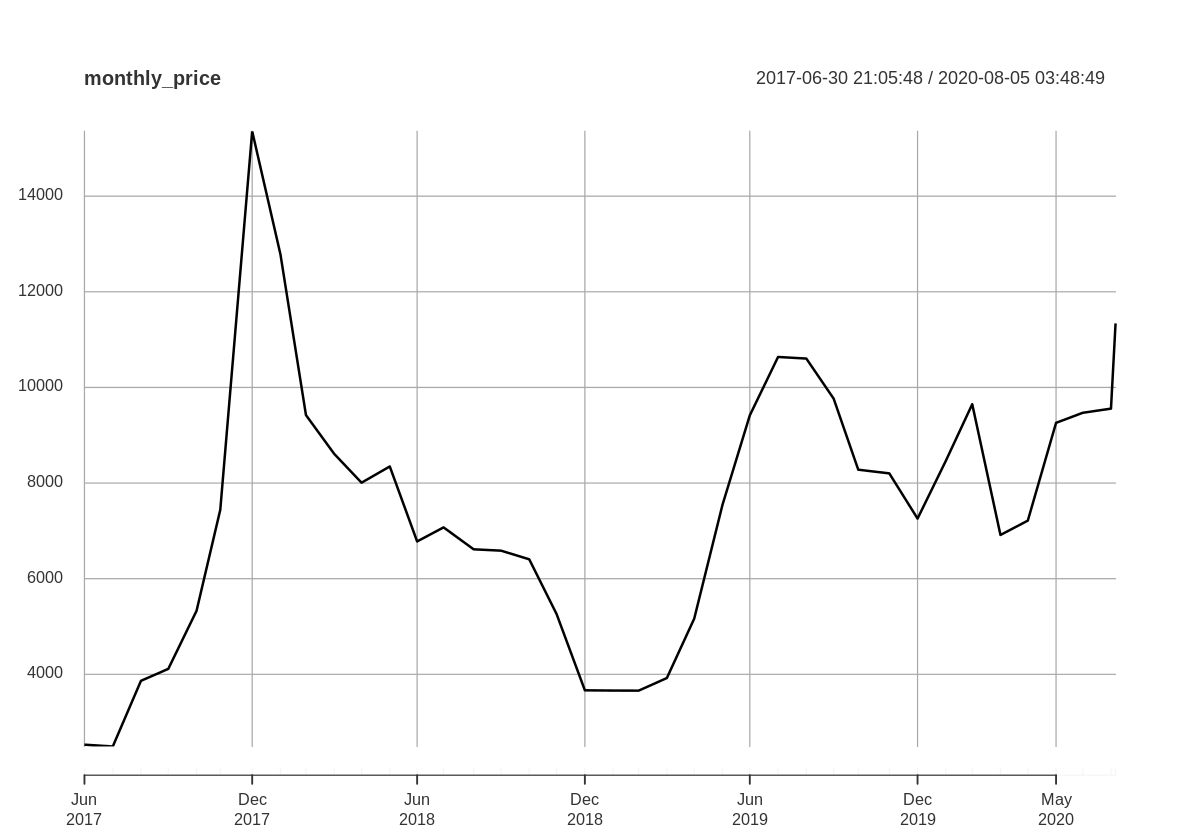

In [15]:
# Plot XBT monthly average prices over time 
plot(monthly_price, yaxis.right = FALSE)

### XBT Quarterly Prices - June 2017 to June 2020

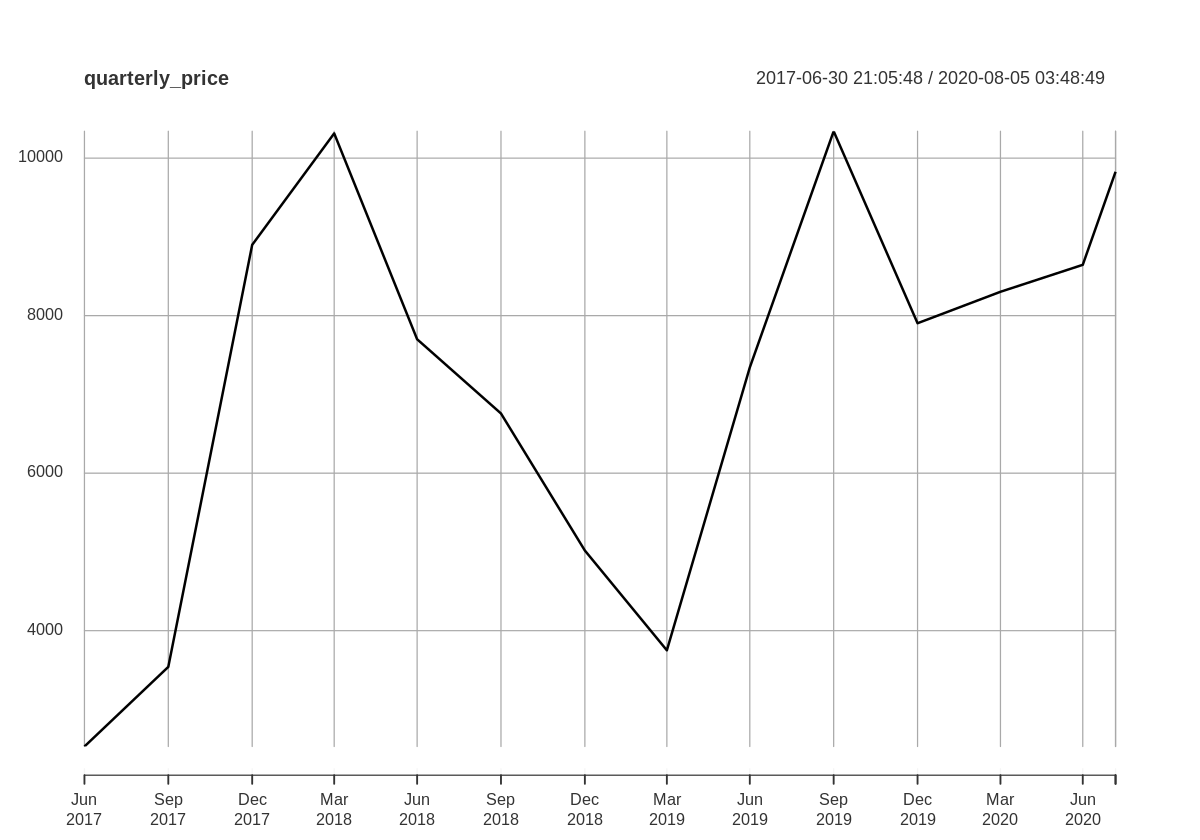

In [16]:
# Plot XBT quarterly average prices over time 
plot(quarterly_price, yaxis.right = FALSE) 

### XBT Prices Over Different Time Periods - June 2017 to June 2020

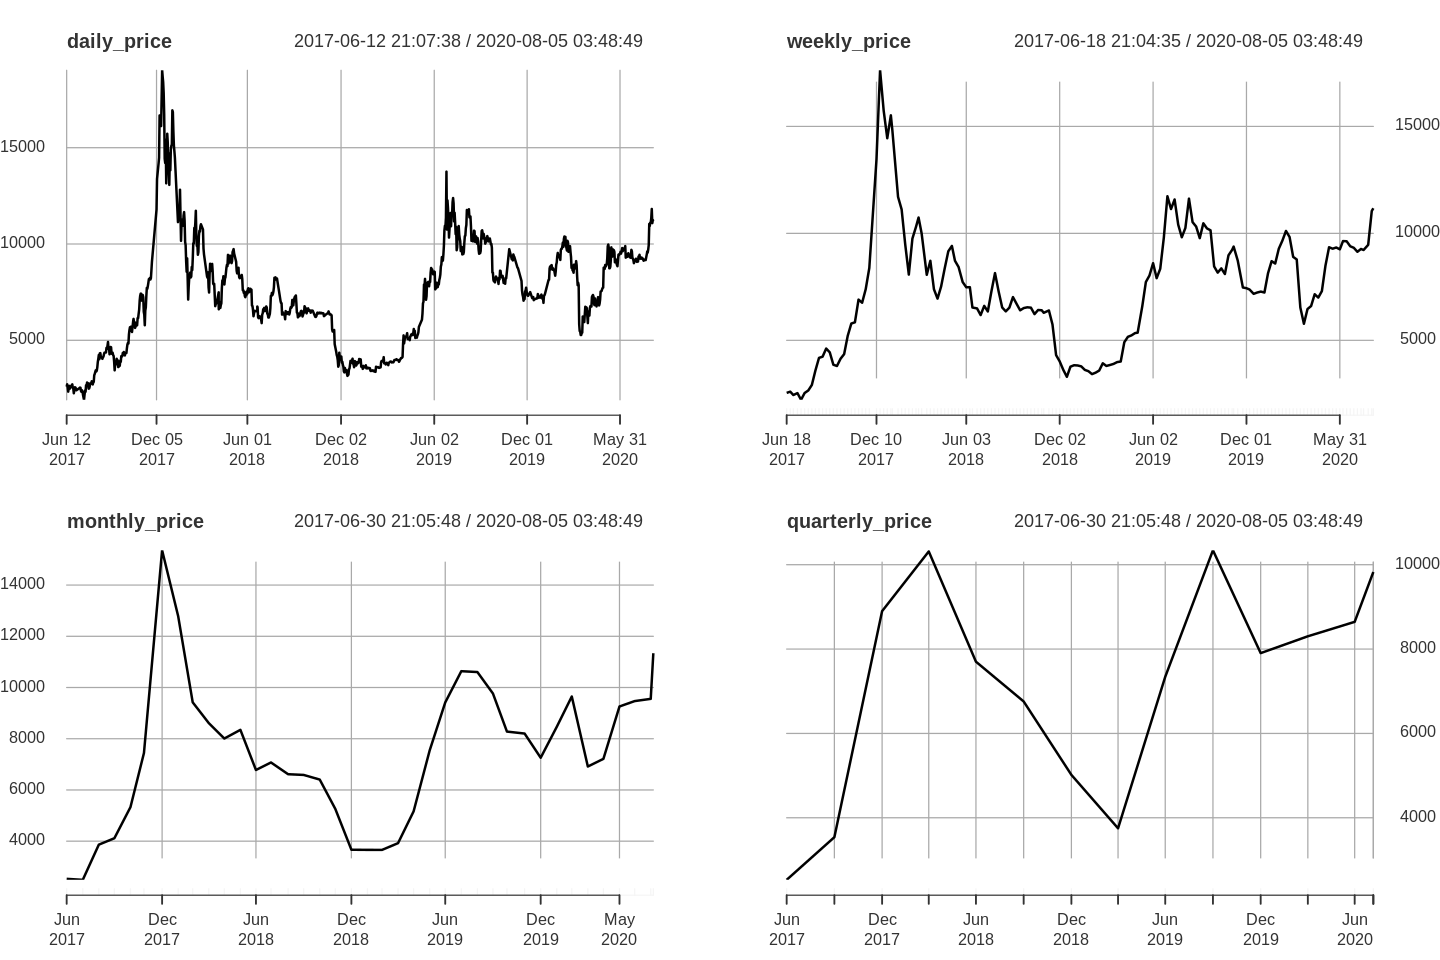

In [17]:
# Allows you to create four plots in 2 rows x 2 columns
par(mfrow=c(2,2))

# Adjusting figure size, you can change the width and height
options(repr.plot.width=12, repr.plot.height=8) 

# Create price curves:
plot(daily_price, yaxis.right = FALSE)
plot(weekly_price, yaxis.left = FALSE)
plot(monthly_price, yaxis.right = FALSE)
plot(quarterly_price, yaxis.left = FALSE)

## Summary

On this lab we learned how to transform raw timeseries data in R. We introduced data pre-processing steps to prepare our dataset for analysis and visualization, and demonstrated how to calculate moving average or prices and plot price curves with the XBT dataset. 

<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>